# Calclul des shap values du modèle CatBoost sur 2 classes

### Imports

In [1]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

## Import des scripts python
import sys
import os
sys.path.append(os.path.abspath('../../python_scripts/'))

#import load_datas
import train_model as train
import save_model as saveModel
#import pickle_model

# Rechargement en cas de modification
import importlib

importlib.reload(train)
importlib.reload(saveModel)
#importlib.reload(pickle_model)

<module 'save_model' from '/home/flakai/Documents/MAR24_CDS_Accidents/Notebooks/Entrainements/python_scripts/save_model.py'>

### Chargement des datasets

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

pd.set_option('display.max_columns', None)


X_train = pd.read_csv("../../../../Data/X_train.zip", compression=dict(method='zip', archive_name='X_train.csv'))
y_train = pd.read_csv("../../../../Data/y_train.zip", compression=dict(method='zip', archive_name='y_train.csv'))['grav']

X_test = pd.read_csv("../../../../Data/X_test.zip", compression=dict(method='zip', archive_name='X_test.csv'))
y_test = pd.read_csv("../../../../Data/y_test.zip", compression=dict(method='zip', archive_name='y_test.csv'))['grav']

print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)

y_train=y_train.replace({1:0})
y_train=y_train.replace({2:1,3:1})

y_test=y_test.replace({1:0})
y_test=y_test.replace({2:1,3:1})


X_train shape : (352893, 337)
X_test shape : (88224, 337)


### Chargement du meilleur modèle catboost

In [3]:
from sklearn.metrics import classification_report

file_name = "../2_grid_search_best_model/best_models/catboost_2_classes.gz"
model = saveModel.load(file_name)

# Prediction du model
y_pred = model.predict(X_test)

# Évaluation du modèle
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     71781
           1       0.46      0.84      0.59     16443

    accuracy                           0.78     88224
   macro avg       0.71      0.80      0.72     88224
weighted avg       0.86      0.78      0.80     88224



## Interprétabilité avec shap

### Shap : Calcul des shap values

In [4]:

import shap

#explainer = shap.KernelExplainer(model.predict_proba,X_test_kmeans)

explainer = shap.TreeExplainer(model,X_test)
# InitJS
shap.initjs()

shap_values = explainer(X_test)

shap_values_save = shap_values

/home/flakai/Documents/MAR24_CDS_Accidents/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|===================| 88221/88224 [277:33<00:00]         

#### Summary plot

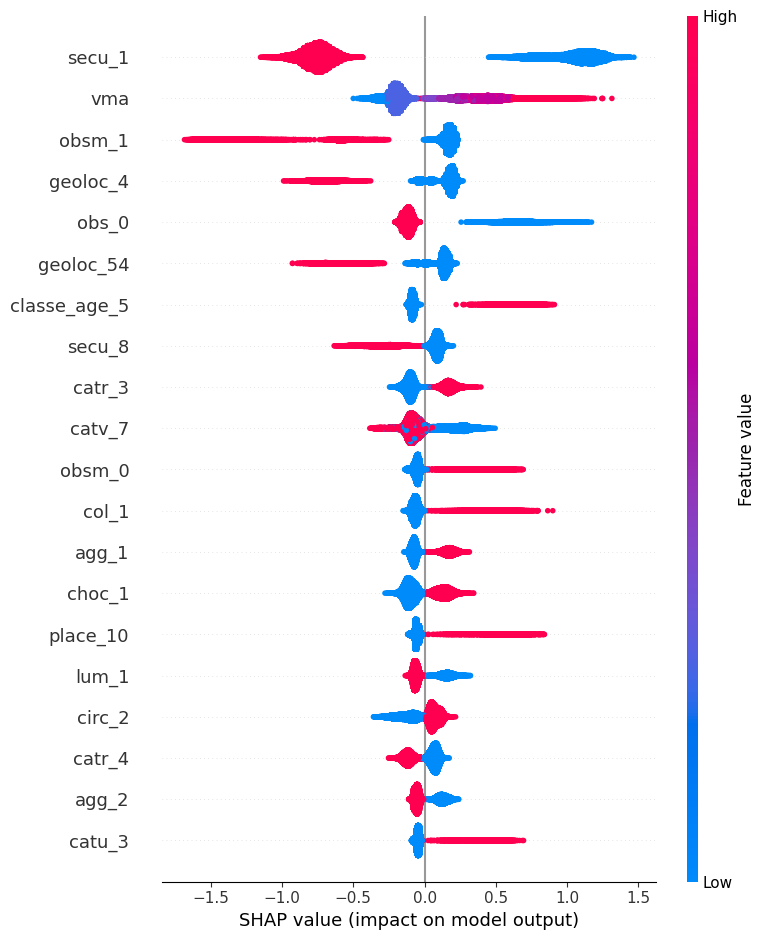

In [5]:
shap.summary_plot(shap_values)

### Sauvegarde de shap value en fichier csv

In [6]:

#for i in range(0,2):
shap_values_i=shap_values
shap_df = pd.DataFrame(shap_values_i.values,index=X_test.index ,columns=X_test.columns)

#shap_df.head()

shap_df['x_test_instance'] = shap_values_i.data.tolist()
shap_df['base_values'] = shap_values_i.base_values

file_name ='shape_value_files/1_final_catboost_values_data_geo'
shap_df.to_csv(file_name +'.zip', index= False, compression=dict(method='zip', archive_name=file_name+'.csv'))



### Relecture du fichier

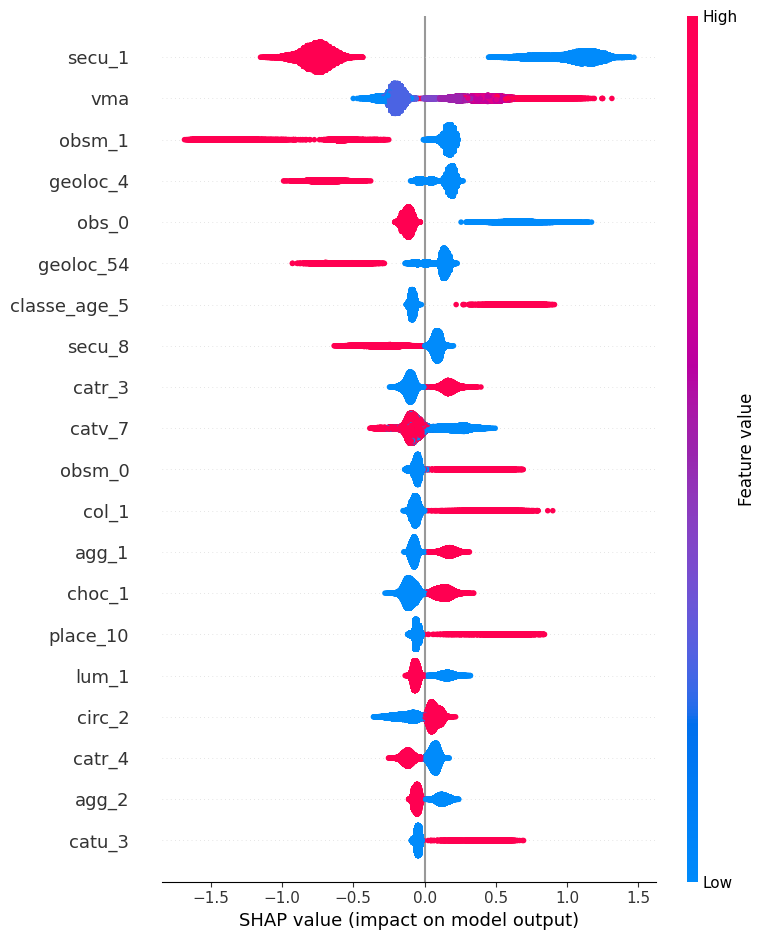

In [7]:
### Relire le fichier et afficher les courbes
import shap
shap_df= pd.read_csv("shape_value_files/1_final_catboost_values_data_geo.zip", \
                      compression=dict(method='zip', archive_name='1_final_catboost_values_data_geo.csv'))

shap_values_csv = shap_df.drop(columns=['x_test_instance','base_values']).values
feature_names = shap_df.drop(columns=['x_test_instance','base_values']).columns

shap_exp = shap.Explanation(values=shap_values_csv, data=X_test, feature_names=feature_names)

shap.summary_plot(shap_exp)